In [12]:
%pip install torch torchvision torchaudio


INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
    --------------------------------------- 0.0/2.4 MB 325.1 kB/s eta 0:00:08
   - -------------------------------------- 0.1/2.4 MB 409.6 kB/s eta 0:00:06
   - -------------------------------------- 0.1/2.4 MB 508.4 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/2.4 MB 479.3 kB/s eta 0:00:05
   -- ------------------------------------- 0.2/2.4 MB 577.4 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.4 MB 577.4 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.4 MB 499.5 kB/s eta 0:00:05
   -- -------------------------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [3]:
# Define the ResNet16 architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
        ) if stride != 1 or in_channels != out_channels else None
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [5]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, 2)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Adds horizontal flipping
    transforms.RandomRotation(15),  # Adds random rotations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# load Dataset
train_dataset = datasets.ImageFolder(root='C:/Users/aishw/Python_Program/leapGestRecog/train', transform=transform)
test_dataset = datasets.ImageFolder(root='C:/Users/aishw/Python_Program/leapGestRecog/test', transform=transform)




In [9]:
test_dataset.classes

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss function, and optimizer
model = ResNet18(num_classes=len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')
torch.save(model.state_dict(), 'C:/Users/aishw/trained_model.pth')

Epoch [1/10], Loss: 0.5910
Epoch [2/10], Loss: 0.0421
Epoch [3/10], Loss: 0.0416
Epoch [4/10], Loss: 0.0038
Epoch [5/10], Loss: 0.0011
Epoch [6/10], Loss: 0.0014
Epoch [7/10], Loss: 0.0031
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0003
Test Accuracy: 0.8672


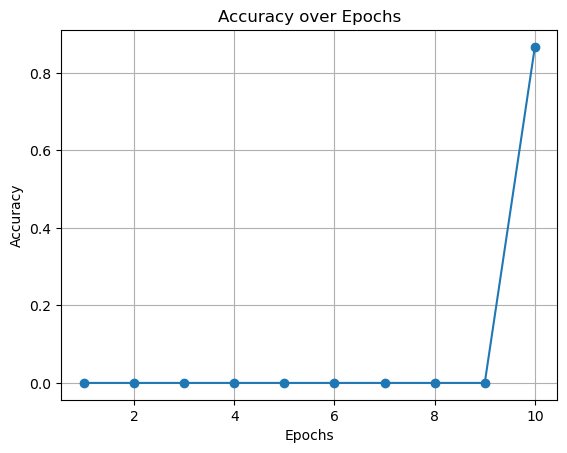

In [2]:
import matplotlib.pyplot as plt

# Define the number of epochs
num_epochs = 10

# Define the loss and accuracy lists with new values
loss_values = [0.5910, 0.0421, 0.0416, 0.0038, 0.0011, 0.0014, 0.0031, 0.0005, 0.0004, 0.0003]
accuracy_values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8672]

# Define the epochs
epochs = range(1, num_epochs + 1)

# Plot accuracy over epochs
plt.plot(epochs, accuracy_values, marker='o', linestyle='-')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
